# **Topic Modelling using Gensim Package**

The csv files to be analysed is sourced from google drive (with file id). This notebook is based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
# pyLDAvis package for plotting
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 6.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=0eb5ac5d863dd3d5275b2d6d9ef60a3ef46207bf8bd59836bd8b0a265d31f9f2
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [3]:
# Standard Models
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','energy'])

In [5]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Download a file based on its file ID
journal='Applied Energy'
file_id = '13--OW3PQ4GMGyTqZBkNvJY1xbTWm_UlY'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('file.csv')
print('Downloaded Data File')

Downloaded Data File


In [7]:
dfs = pd.read_csv('file.csv', header=None, names=['Publication','CoverDate', 'Title', 'Keywords','Abstract','PII'], encoding='ISO-8859-1')
m_corpus = pd.DataFrame()

In [8]:
# Creating the abridgement - "Keywords" + "Title"
keyword_corpus = pd.DataFrame()
keyword_corpus['Keywords'] = dfs['Keywords'] + ',' + dfs['Title']
# Please note that "Keywords" referenced indicates "Keywords"+"Title" (i.e. abrigement) from this section

In [9]:
keyword_corpus.dropna(inplace=True)
keyword_corpus.reset_index(drop=True, inplace=True)
keyword_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17614 entries, 0 to 17613
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Keywords  17614 non-null  object
dtypes: object(1)
memory usage: 137.7+ KB


In [11]:
def preprocess(str) :
    #Remove punctuations
    text = re.sub('[^a-zA-Z0-9]', ' ', str)
    
    #Convert to lowercase
    text = str.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters
    text=re.sub("(\\W)+"," ",text)

    if text in stop_words:
      return None

    return text

In [12]:
prpr_corpus = []
for word in keyword_corpus['Keywords']:
    text = preprocess(word) 
    if text is not None:
      prpr_corpus.append(text)

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(prpr_corpus))

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [15]:
# Remove Stop Words
data_words = remove_stopwords(data_words)

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('analytical', 1),
  ('cauchy', 1),
  ('central', 1),
  ('convolution', 2),
  ('flux', 1),
  ('image', 1),
  ('integral', 2),
  ('kernel', 1),
  ('mapping', 1),
  ('model', 1),
  ('modeling', 1),
  ('plane', 1),
  ('platform', 1),
  ('quasi', 1),
  ('radiative', 1),
  ('receiver', 1),
  ('system', 1),
  ('via', 1)]]

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=5, limit=25, step=5)

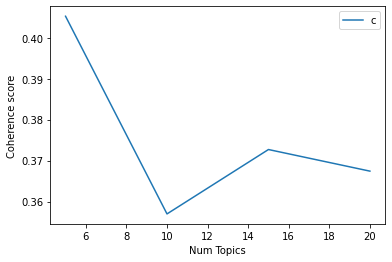

In [20]:
# Show graph
limit=25; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4053
Num Topics = 10  has Coherence Value of 0.357
Num Topics = 15  has Coherence Value of 0.3727
Num Topics = 20  has Coherence Value of 0.3674


In [22]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.056*"solar" + 0.038*"thermal" + 0.036*"fuel" + 0.021*"diesel" + '
  '0.017*"cell" + 0.016*"air" + 0.014*"storage" + 0.014*"performance" + '
  '0.012*"transfer" + 0.011*"saving" + 0.010*"oxide" + 0.010*"radiation" + '
  '0.010*"change" + 0.009*"sustainability" + 0.008*"experimental" + '
  '0.008*"micro" + 0.008*"material" + 0.007*"transport" + 0.007*"phase" + '
  '0.007*"investigation" + 0.007*"fuels" + 0.007*"membrane" + 0.006*"effect" + '
  '0.006*"solid" + 0.006*"heater" + 0.005*"cells" + 0.005*"reduction" + '
  '0.005*"generator" + 0.005*"alternative" + 0.005*"sunshine" + 0.005*"tube" + '
  '0.005*"using" + 0.005*"environment" + 0.005*"operating" + '
  '0.005*"applications" + 0.004*"speed" + 0.004*"direct" + 0.004*"zinc" + '
  '0.004*"circulation" + 0.004*"study"'),
 (1,
  '0.038*"gas" + 0.033*"water" + 0.028*"combustion" + 0.025*"engine" + '
  '0.021*"turbine" + 0.019*"simulation" + 0.015*"performance" + '
  '0.014*"biodiesel" + 0.014*"flow" + 0.011*"steam" + 0.011*"fuel"

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
model_topics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.082*"fuel" + 0.047*"engine" + 0.030*"flow" + 0.029*"cell" + '
  '0.027*"biodiesel" + 0.025*"combustion" + 0.024*"performance" + '
  '0.021*"emission" + 0.019*"effect" + 0.017*"emissions" + 0.016*"scale" + '
  '0.015*"effects" + 0.014*"oxide" + 0.014*"characteristics" + 0.013*"direct" '
  '+ 0.011*"ignition" + 0.010*"small" + 0.009*"duration" + 0.008*"optimum" + '
  '0.008*"tube"'),
 (1,
  '0.132*"heat" + 0.033*"waste" + 0.032*"simulation" + 0.031*"recovery" + '
  '0.026*"transfer" + 0.026*"temperature" + 0.020*"experimental" + '
  '0.018*"steam" + 0.018*"pump" + 0.016*"performance" + 0.015*"thermal" + '
  '0.013*"bed" + 0.013*"exchanger" + 0.011*"absorption" + 0.011*"air" + '
  '0.010*"study" + 0.009*"micro" + 0.009*"conversion" + 0.009*"heater" + '
  '0.009*"refrigeration"'),
 (2,
  '0.079*"power" + 0.038*"system" + 0.034*"generation" + 0.027*"model" + '
  '0.026*"systems" + 0.023*"based" + 0.020*"natural" + 0.020*"plant" + '
  '0.020*"modeling" + 0.019*"gas" + 0.019*"design

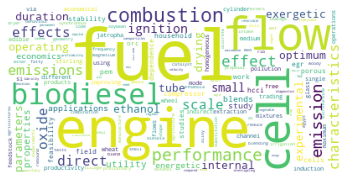

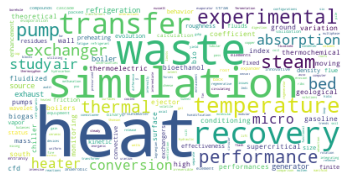

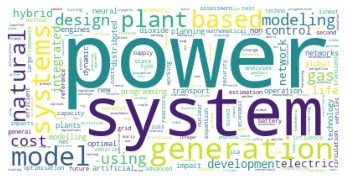

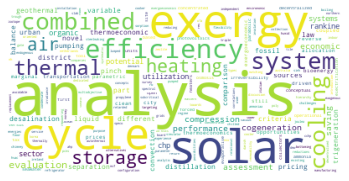

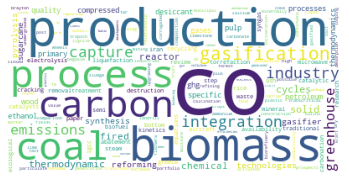

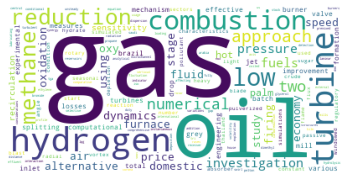

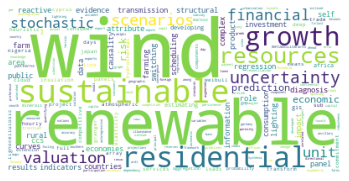

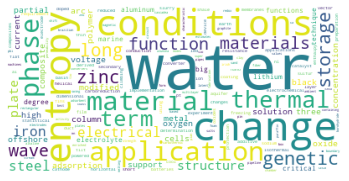

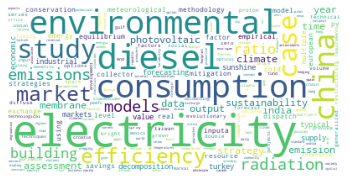

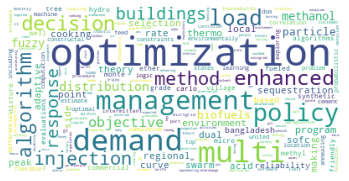

In [ ]:
# WordClouds
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    #plt.title("Cluster #" + str(t+1))
    plt.show()

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.851856899905799

Coherence Score:  0.31835691402100796


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.302136 -0.016279       1        1  17.345176
3      0.196796  0.228162       2        1  13.207782
8      0.068825 -0.096596       3        1  10.356756
1     -0.137772  0.216028       4        1  10.164926
5     -0.050725  0.040034       5        1   9.399603
4     -0.191253 -0.134478       6        1   9.358449
0     -0.175177  0.071787       7        1   9.071117
9      0.027949 -0.192848       8        1   8.124764
7     -0.064558  0.074046       9        1   7.183000
6      0.023780 -0.189855      10        1   5.788426, topic_info=             Term         Freq        Total Category  logprob  loglift
23           heat  5107.000000  5107.000000  Default  30.0000  30.0000
82       analysis  5252.000000  5252.000000  Default  29.0000  29.0000
26          power  5208.000000  5208.000000  Default  28.0000  28.0000
85           fuel  2842.000000  2842.000000  Default  27.0000  27.0000
117            co  2833.000000  2833.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1287        rural   123.206683   124.217019  Topic10  -5.1856   2.8411
668    scheduling   121.655584   122.665933  Topic10  -5.1983   2.8410
970          farm   118.353785   119.364122  Topic10  -5.2258   2.8408
54       economic   227.615757  1462.567874  Topic10  -4.5718   0.9890
138   consumption   185.508720  1180.818124  Topic10  -4.7764   0.9984

[386 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
45        4  0.998613  absorption
936       9  0.997186  adsorption
95        2  0.603230         air
95        4  0.255935         air
95        5  0.140170         air
...     ...       ...         ...
306      10  0.999484        wind
1674      6  0.993539        wood
1373      7  0.996732        work
446       3  0.996363        year
1256      9  0.997326        zinc

[384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 9, 2, 6, 5, 1, 10, 8, 7])

In [ ]:
pyLDAvis.save_html(vis, 'lda_energy.html')